In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from tensorflow.keras.applications import imagenet_utils

In [ ]:
image=np.array(load_img('input_image_path',target_size=(224,224)))
print(image.shape)
plt.imshow(image)
plt.axis('off')
# image=np.expand_dims(image,axis=0)
# print(image.shape)


In [ ]:
model=ResNet50()

In [ ]:
for layer in reversed(model.layers):
  if len(layer.output.shape)==4:
    last_conv_layer_name=layer.name
    break
print(last_conv_layer_name)

In [ ]:
last_conv_layer=model.get_layer(last_conv_layer_name)
last_conv_layer_model=Model(model.inputs,last_conv_layer.output)

In [ ]:

tf.keras.utils.plot_model(model, "resnet50.png", show_shapes=True)


In [ ]:
last_conv_layer.output.shape[1:]

TensorShape([7, 7, 2048])

In [ ]:
classifier_model=Model(last_conv_layer_model.output,model.output)

In [ ]:
with tf.GradientTape() as tape:
  inputs=image[np.newaxis,...]
  last_conv_output=last_conv_layer_model(inputs)
  tape.watch(last_conv_output)
  pred=classifier_model(last_conv_output)
  top_pred_index=tf.argmax(pred[0])
  top_pred_prob=tf.reduce_max(pred[0]) #reduce_max find max value in entire tensor


In [ ]:
grads=tape.gradient(top_pred_prob,last_conv_output)

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [ ]:
last_conv_output.shape

TensorShape([1, 7, 7, 2048])

In [ ]:
last_conv_output.numpy()[0].shape

(7, 7, 2048)

In [ ]:
last_conv_output=last_conv_output.numpy()[0] # removing added dimension
pooled_grads=pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_output[:, :, i] *= pooled_grads[i]

In [ ]:
grad_cam=np.mean(last_conv_output,axis=-1)

In [ ]:
grad_cam.shape


(7, 7)

In [ ]:
grad_cam = np.clip(grad_cam, 0, np.max(grad_cam)) / np.max(grad_cam)
grad_cam = cv2.resize(grad_cam, (224, 224))

(-0.5, 223.5, 223.5, -0.5)

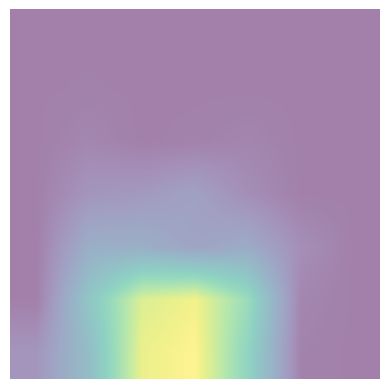

In [ ]:

plt.imshow(grad_cam,alpha=0.5)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

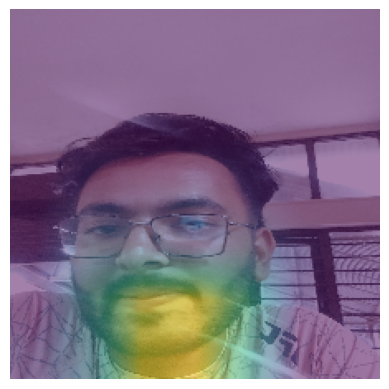

In [ ]:
plt.imshow(image)
plt.imshow(grad_cam,alpha=0.5)
plt.axis('off')

slightly tweaking Grad_CAM we can find explainations to the regions that can change network predictions. Hence , removing concepts from those regions will make network more confident about its predictions.

(-0.5, 223.5, 223.5, -0.5)

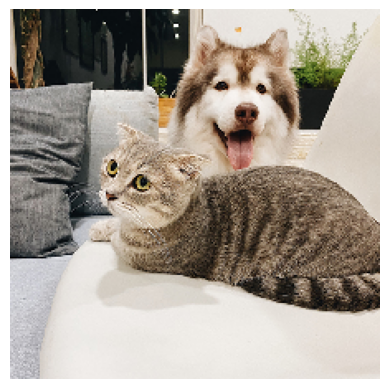

In [ ]:
image2=np.array(load_img('input_image_path',target_size=(224,224)))
plt.imshow(image2)
plt.axis('off')

In [ ]:
with tf.GradientTape() as tape:
  inputs=image2[np.newaxis,...]
  last_conv_output=last_conv_layer_model(inputs)
  tape.watch(last_conv_output)
  pred=classifier_model(last_conv_output)
  top_pred_index=tf.argmax(pred[0])
  top_pred_prob=tf.reduce_max(pred[0])

In [ ]:
grad=tape.gradient(top_pred_prob,last_conv_output)

In [ ]:
pooled_grad=tf.reduce_mean(-1*grad,axis=(0,1,2))

In [ ]:
pooled_grad=pooled_grad.numpy()
last_conv_output=last_conv_output.numpy()[0]
for i in range(pooled_grad.shape[-1]):
  last_conv_output[:,:,i]*=pooled_grad[i]

In [ ]:
ctfcl_gradcam=np.mean(last_conv_output,axis=-1)
ctfcl_gradcam=np.clip(ctfcl_gradcam,0,np.max(ctfcl_gradcam))/np.max(ctfcl_gradcam)
ctfcl_gradcam=cv2.resize(ctfcl_gradcam,(224,224))

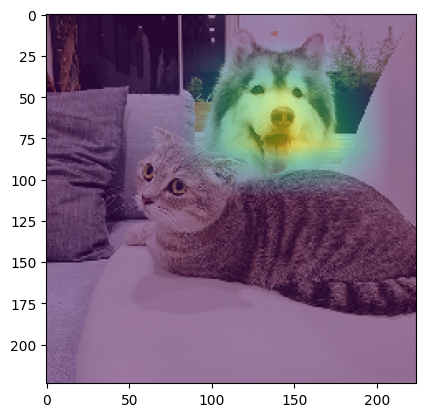

In [ ]:
plt.imshow(image2)
plt.imshow(ctfcl_gradcam,alpha=0.5)
plt.axis('off')

**MASKING**

In [ ]:
ctfcl_gradcam.shape


(224, 224)

In [ ]:
mask = cv2.resize(ctfcl_gradcam, (224, 224))
mask[mask > 0.1] = 255
mask[mask != 255] = 0
mask = mask.astype(bool)

In [ ]:
ctfctl_image = image2.copy()
ctfctl_image[mask] = (0, 0, 0)


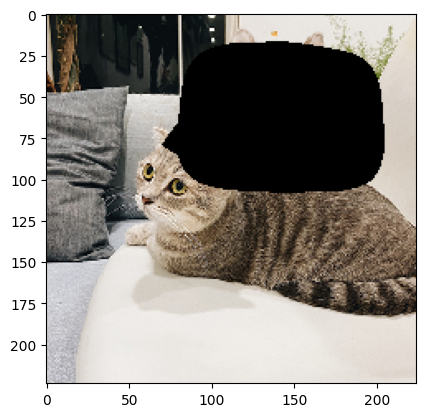

In [ ]:
plt.imshow(ctfctl_image)
plt.axis('off')

In [ ]:
decode_predictions(model.predict(image[np.newaxis, ...]))


1/1 [==============================] - 2s 2s/step


[[('n02883205', 'bow_tie', 0.5255998),
  ('n04590129', 'window_shade', 0.07699796),
  ('n03000247', 'chain_mail', 0.0723333),
  ('n03814639', 'neck_brace', 0.046259418),
  ('n03724870', 'mask', 0.039929297)]]

In [ ]:
decode_predictions(model.predict(ctfctl_image[np.newaxis, ...]))


1/1 [==============================] - 0s 277ms/step


[[('n02124075', 'Egyptian_cat', 0.60259396),
  ('n02123045', 'tabby', 0.0400066),
  ('n04254777', 'sock', 0.036934588),
  ('n02834397', 'bib', 0.031781174),
  ('n03814639', 'neck_brace', 0.017812634)]]

**Guided Grad CAM**

In [ ]:
image=np.array(load_img('input_image_path',target_size=(224,224)))

(-0.5, 223.5, 223.5, -0.5)

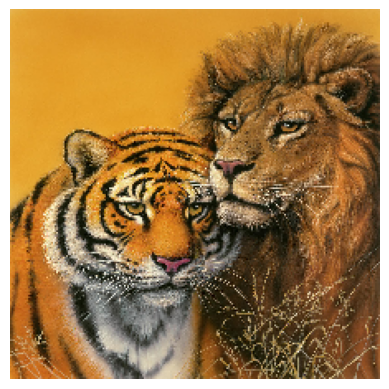

In [ ]:
plt.imshow(image)
plt.axis('off')

In [ ]:
with tf.GradientTape() as tape:
  input=image[np.newaxis,...]
  last_conv_output=last_conv_layer_model(input)
  tape.watch(last_conv_output)
  pred=classifier_model(last_conv_output)
  top_pred_index=tf.argmax(pred[0])
  top_pred_prob=tf.reduce_max(pred[0])

In [ ]:
grad=tape.gradient(top_pred_prob,last_conv_output)[0]


In [ ]:
last_conv_output=last_conv_output[0]

In [ ]:
cast_last_conv_output=tf.cast(last_conv_output>0,'float32')
cast_grad=tf.cast(grad>0,'float32')

In [ ]:
guided_grads=cast_last_conv_output*cast_grad*grad

In [ ]:
guided_grads.shape

TensorShape([7, 7, 2048])

In [ ]:
pooled_guided_grads=tf.reduce_mean(guided_grads,axis=(0,1))
guided_gradcam=np.ones(last_conv_output.shape[:2],dtype=np.float32)

In [ ]:
pooled_guided_grads.shape

TensorShape([2048])

In [ ]:
guided_gradcam.shape

(7, 7)

In [ ]:
for i,w in enumerate(pooled_guided_grads):
  guided_gradcam+=w*last_conv_output[:,:,i]

In [ ]:
guided_gradcam

<tf.Tensor: shape=(7, 7), dtype=float32, numpy=
array([[1.0025414, 1.0021508, 1.0020477, 1.0027083, 1.0024533, 1.0028477,
        1.002461 ],
       [1.0040796, 1.0057251, 1.0103906, 1.0226825, 1.0270952, 1.0242856,
        1.0157275],
       [1.0059209, 1.0209675, 1.0457262, 1.0596116, 1.0751512, 1.0582739,
        1.0302345],
       [1.017148 , 1.0548922, 1.0923936, 1.0906886, 1.0805616, 1.0555861,
        1.0249592],
       [1.032437 , 1.0728343, 1.0949467, 1.078    , 1.0696657, 1.0359414,
        1.0143197],
       [1.0314157, 1.0637558, 1.0894594, 1.0615994, 1.0412008, 1.0274066,
        1.0141628],
       [1.0210129, 1.0341811, 1.050464 , 1.0465606, 1.0335014, 1.0198908,
        1.0160224]], dtype=float32)>

In [ ]:
guided_gradcam=cv2.resize(guided_gradcam.numpy(),(224,224))

In [ ]:
guided_gradcam=np.clip(guided_gradcam,0,np.max(guided_gradcam))

In [ ]:
guided_gradcam=(guided_gradcam-np.min(guided_gradcam))/(np.max(guided_gradcam)-np.min(guided_gradcam))

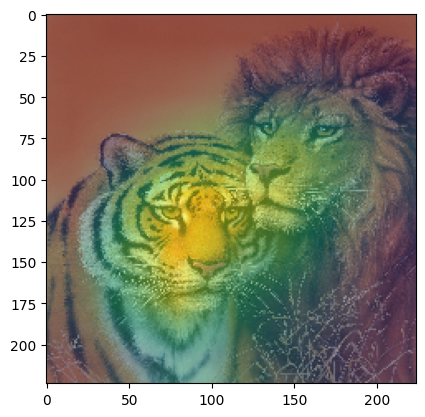

In [ ]:
plt.imshow(image)
plt.imshow(guided_gradcam,alpha=0.5)

**Guided Gradcam (high resolution)**

In [ ]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [ ]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [ ]:
gb = GuidedBackprop(model, "conv5_block3_out")

In [ ]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()


In [ ]:
saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)


In [ ]:
saliency_map = (saliency_map-saliency_map.mean())/saliency_map.std()
saliency_map *= 0.25
saliency_map += 0.5
saliency_map = np.clip(saliency_map, 0, 1)
saliency_map *= 255
saliency_map = saliency_map.astype(np.uint8)



(-0.5, 223.5, 223.5, -0.5)

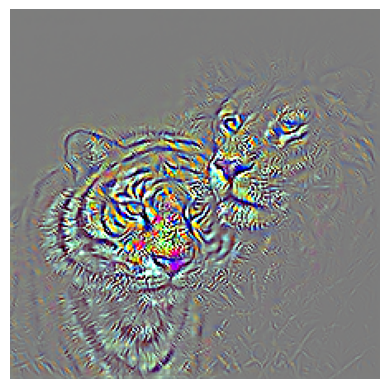

In [ ]:
plt.imshow(saliency_map)
plt.axis('off')